# Training Locally on Plaintext Data

In [1]:
import time
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use('dark_background')

import h5py
import numpy as np
import tenseal as ts
import torch
import torch.nn as nn
import torch.nn.functional as F
from icecream import ic
ic.configureOutput(includeContext=True)
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, Dataset

print(f'torch version: {torch.__version__}')
print(f'tenseal version: {ts.__version__}')

project_path = Path.cwd().parent
print(f'project_path: {project_path}')

torch version: 1.8.1+cu102
tenseal version: 0.3.10
project_path: /home/dk/Desktop/projects/HESplit


## Dataset

In [2]:
class ECG(Dataset):
    """The class used by the client to load the dataset

    Args:
        Dataset ([type]): [description]
    """
    def __init__(self, train=True):
        if train:
            with h5py.File(project_path/'data/train_ecg.hdf5', 'r') as hdf:
                self.x = hdf['x_train'][:]
                self.y = hdf['y_train'][:]
        else:
            with h5py.File(project_path/'data/test_ecg.hdf5', 'r') as hdf:
                self.x = hdf['x_test'][:]
                self.y = hdf['y_test'][:]
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx], dtype=torch.float), torch.tensor(self.y[idx])

In [3]:
batch_size = 4
train_dataset = ECG(train=True)
test_dataset = ECG(train=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [6]:
print(len(train_dataset), len(test_dataset))
print(train_dataset[0][0].shape)

13245 13245
torch.Size([1, 128])


## Training loop

In [4]:
epoch = 10
lr = 0.001
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f'device: {torch.cuda.get_device_name(0)}')

device: NVIDIA GeForce GTX 1070 Ti


In [5]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [6]:
def train(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)

    train_losses = list()
    train_accs = list()
    train_times = list()

    test_losses = list()
    test_accs = list()
    test_times = list()

    best_test_acc = 0  # best test accuracy 

    for e in range(epoch):
        train_start = time.time()
        print("Epoch {} - ".format(e+1), end='')

        # train
        train_loss = 0.0
        correct, total = 0, 0
        for i, batch in enumerate(train_loader):
            x, label = batch  # get feature and label from a batch
            x, label = x.to(device), label.to(device)  # send to device
            optimizer.zero_grad()  # init all grads to zero
            output = model(x)  # forward propagation
            loss = criterion(output, label)  # calculate loss
            loss.backward()  # backward propagation
            optimizer.step()  # weight update

            train_loss += loss.item()
            correct += torch.sum(output.argmax(dim=1) == label).item()
            total += len(label)

        train_losses.append(train_loss / len(train_loader))
        train_accs.append(correct / total)
        train_end = time.time()
        train_times.append(train_end-train_start)
        print("loss: {:.4f}, acc: {:.2f}%".format(train_losses[-1], train_accs[-1]*100), end=' / ')
    
        # test
        test_start = time.time()
        with torch.no_grad():
            test_loss = 0.0
            correct, total = 0, 0
            for _, batch in enumerate(test_loader):
                x, label = batch
                x, label = x.to(device), label.to(device)
                output = model(x)
                loss = criterion(output, label)
                
                test_loss += loss.item()
                correct += torch.sum(output.argmax(dim=1) == label).item()
                total += len(label)
            test_losses.append(test_loss / len(test_loader))
            test_accs.append(correct / total)
        test_end = time.time()
        test_times.append(test_end-test_start)
        print("test_loss: {:.4f}, test_acc: {:.2f}%".format(test_losses[-1], test_accs[-1]*100))

    return train_losses, train_accs, train_times, test_losses, test_accs, test_times

## Model

In [2]:
class ECGConv1D(nn.Module):
    def __init__(self):
        super(ECGConv1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, 
                               out_channels=16, 
                               kernel_size=7, 
                               padding=3,
                               stride=1)  # 16 x 128
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool1d(2)  # 16 x 64
        self.conv2 = nn.Conv1d(in_channels=16, 
                               out_channels=8, 
                               kernel_size=5, 
                               padding=2)  # 8 x 64
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool1d(2)  # 8 x 32 = 256
        
        self.linear = nn.Linear(256, 5)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 256)
        x = self.linear(x)
        x = self.softmax(x)
        return x

ecgnet = ECGConv1D()

<generator object Module.parameters at 0x7f1efce0f200>

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(ecgnet)

2061

In [8]:

train_losses, train_accs, train_times, \
        test_losses, test_accs, test_times = train(ecgnet.to(device))
torch.save(ecgnet.state_dict(), './weights/trained_weight.pth')  # save trained weights    

Epoch 1 - loss: 1.2800, acc: 63.86% / test_loss: 1.1750, test_acc: 75.02%
Epoch 2 - loss: 1.1591, acc: 75.33% / test_loss: 1.1305, test_acc: 78.04%
Epoch 3 - loss: 1.1167, acc: 79.18% / test_loss: 1.0763, test_acc: 83.23%
Epoch 4 - loss: 1.0686, acc: 84.21% / test_loss: 1.0504, test_acc: 85.90%
Epoch 5 - loss: 1.0549, acc: 85.35% / test_loss: 1.0379, test_acc: 86.95%
Epoch 6 - loss: 1.0502, acc: 85.61% / test_loss: 1.0347, test_acc: 87.19%
Epoch 7 - loss: 1.0457, acc: 86.08% / test_loss: 1.0306, test_acc: 87.51%
Epoch 8 - loss: 1.0444, acc: 86.20% / test_loss: 1.0287, test_acc: 87.66%
Epoch 9 - loss: 1.0415, acc: 86.36% / test_loss: 1.0270, test_acc: 87.90%
Epoch 10 - loss: 1.0377, acc: 86.70% / test_loss: 1.0243, test_acc: 88.06%


In [12]:
print(f'best test accuracy: {max(test_accs)*100:.2f} at epoch {np.array(test_accs).argmax() + 1}')
print(f'avg training time for one epoch: {np.mean(train_times):.2f}s') 
print(f'avg testing time for one epoch: {np.mean(test_times):.2f}s')

best test accuracy: 88.06 at epoch 10
avg training time for one epoch: 4.80s
avg testing time for one epoch: 1.55s


## Visualizing results

In [10]:
df = pd.DataFrame({  # save model training process into csv file
    'loss': train_losses,
    'test_loss': test_losses,
    'acc': train_accs,
    'test_acc': test_accs
})
df.to_csv('outputs/loss_and_acc.csv')

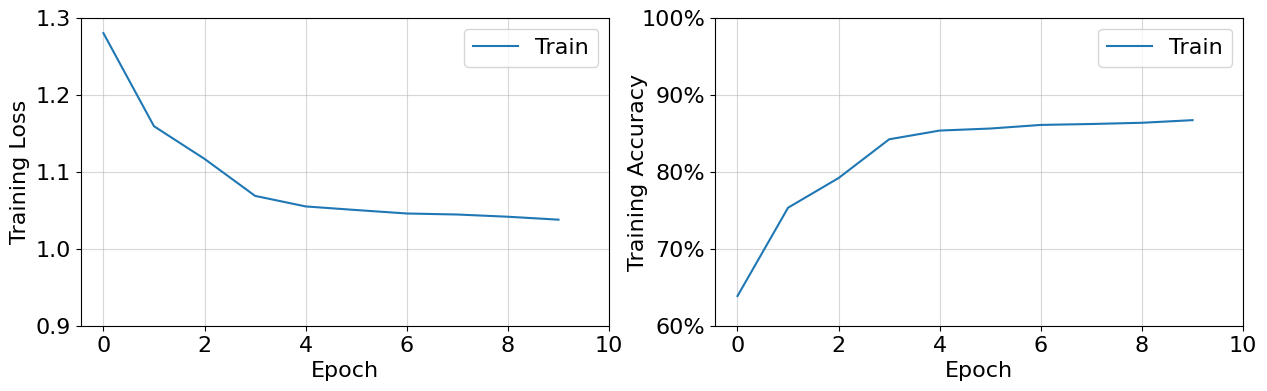

In [11]:
plt.style.use('default')
test_accs = df['test_acc']
train_accs = df['acc']
test_losses = df['test_loss']
train_losses = df['loss']

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].plot(train_losses)
# ax[0].plot(test_losses)
ax[0].set_xticks([0, 2, 4, 6, 8, 10])
ax[0].set_xlabel('Epoch', size=16)
ax[0].set_ylabel('Training Loss', size=16)
ax[0].set_ylim(0.9, 1.1)
ax[0].set_yticks([0.9, 1.0, 1.1, 1.2, 1.3])
ax[0].grid(alpha=0.5)
ax[0].tick_params(labelsize=16)
ax[0].legend(['Train', 'Test'], loc='upper right', fontsize=16)

ax[1].set_ylim(0.7, 1.0)
ax[1].set_yticks([0.6, 0.7, 0.8, 0.9, 1.0])
ax[1].plot(train_accs)
# ax[1].plot(test_accs)
yt = ax[1].get_yticks()
ax[1].set_yticklabels(['{:,.0%}'.format(x) for x in yt])
ax[1].set_xticks([0, 2, 4, 6, 8, 10])
ax[1].set_xlabel('Epoch', size=16)
ax[1].set_ylabel('Training Accuracy', size=16, labelpad=-5)
ax[1].grid(alpha=0.5)
ax[1].tick_params(labelsize=16)
ax[1].legend(['Train', 'Test'], loc='upper right', fontsize=16)

# fig.savefig('loss_acc_conv2_seed.pdf', bbox_inches='tight')

